<a href="https://colab.research.google.com/github/tnfru/colab_research/blob/master/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import sys
if 'google.colab' in sys.modules:
  %tensorflow_version 2.x
import tensorflow as tf
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.layers import LeakyReLU, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

AUTO = tf.data.experimental.AUTOTUNE
l = tf.keras.layers

TensorFlow 2.x selected.


Using TensorFlow backend.


In [2]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus)
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy()
  print('Running on CPU')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Running on  1  GPU(s) 


In [0]:
IMG_SIZE = [28, 28]
BATCH_SIZE = 128

In [0]:
(X, Y), (X_test, Y_test) = mnist.load_data()

In [5]:
np.isnan(X).sum(), np.isnan(X_test).sum()

(0, 0)

In [0]:
def norm_data(X):
  X = X / 255.0
  #X = X - X.mean(axis=0)
  X = X.reshape(-1, *IMG_SIZE, 1)

  return X

In [0]:
X = norm_data(X)
X_test = norm_data(X_test)

In [8]:
X.shape

(60000, 28, 28, 1)

In [0]:
def discriminator():
  discriminator = tf.keras.Sequential([
      l.Conv2D(16, 3, padding='same', input_shape=(*IMG_SIZE, 1)),
      l.LeakyReLU(),
      l.Dropout(0.4),
      
      l.Conv2D(32, 3, padding='same', strides=2),
      l.LeakyReLU(),
      l.Dropout(0.4),

      l.Conv2D(64, 3, padding='same', strides=2),
      l.LeakyReLU(),
      l.Dropout(0.4),


      l.Conv2D(128, 3, padding='same', strides=2),
      l.LeakyReLU(),
      l.Dropout(0.4),

      l.Conv2D(256, 3, padding='same', strides=2),
      l.LeakyReLU(),
      l.Dropout(0.4),


      l.Conv2D(512, 3, padding='same', strides=2),
      l.LeakyReLU(),
      l.Dropout(0.4),

      l.Flatten(),
      l.Dense(1, activation='sigmoid')
  ]) 
  
  #discriminator.summary()

  return discriminator

In [10]:
discriminator().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          1

In [0]:
def discriminator_tut():
    
    net = tf.keras.Sequential()
    input_shape = (28, 28, 1)
    dropout_prob = 0.4

    net.add(l.Conv2D(64, 5, strides=2, input_shape=input_shape, padding='same'))
    net.add(l.LeakyReLU())
    
    net.add(l.Conv2D(128, 5, strides=2, padding='same'))
    net.add(l.LeakyReLU())
    net.add(l.Dropout(dropout_prob))
    
    net.add(l.Conv2D(256, 5, strides=2, padding='same'))
    net.add(l.LeakyReLU())
    net.add(l.Dropout(dropout_prob))
    
    net.add(l.Conv2D(512, 5, strides=1, padding='same'))
    net.add(l.LeakyReLU())
    net.add(l.Dropout(dropout_prob))
    
    net.add(l.Flatten())
    net.add(l.Dense(1))
    net.add(l.Activation('sigmoid'))
    
    return net

In [0]:
def generator_tut():
    
    net = Sequential()
    dropout_prob = 0.4
    
    net.add(Dense(7*7*256, input_dim=100))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    net.add(Reshape((7,7,256)))
    net.add(Dropout(dropout_prob))
    
    net.add(UpSampling2D())
    net.add(Conv2D(128, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(UpSampling2D())
    net.add(Conv2D(64, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(Conv2D(32, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(Conv2D(1, 5, padding='same'))
    net.add(Activation('sigmoid'))
    
    return net

In [0]:
def generator():
  generator = tf.keras.Sequential([
      l.Dense(7 * 7 * 256, input_dim=100),
      l.BatchNormalization(momentum=0.9),
      l.LeakyReLU(),
      l.Reshape((7, 7, 256)),
      l.Dropout(0.4),

      l.UpSampling2D(),
      l.Conv2D(128, 5, padding='same'),
      l.BatchNormalization(momentum=0.9),
      l.LeakyReLU(),
      l.Conv2D(128, 5, padding='same'),
      l.BatchNormalization(momentum=0.9),
      l.LeakyReLU(),

      l.UpSampling2D(),
      l.Conv2D(64, 5, padding='same'),
      l.BatchNormalization(momentum=0.9),
      l.LeakyReLU(),
      l.Conv2D(64, 5, padding='same'),
      l.BatchNormalization(momentum=0.9),
      l.LeakyReLU(),

      l.Conv2D(32, 5, padding='same'),
      l.BatchNormalization(momentum=0.9),
      l.LeakyReLU(),

      l.Conv2D(1, 5, padding='same'),
      l.Activation('sigmoid')
  ])

  #generator.summary()

  return generator

In [0]:
def create_models():
  optim_discriminator = tf.keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-10)

  model_discriminator = tf.keras.Sequential()
  #net_discriminator = discriminator_tut()
  net_discriminator = discriminator()
  model_discriminator.add(net_discriminator)
  model_discriminator.compile(loss='binary_crossentropy', 
                                optimizer=optim_discriminator, 
                                metrics=['accuracy'])
      
  optim_adversarial = tf.keras.optimizers.Adam(lr=0.0004, clipvalue=1.0, decay=1e-10)

  model_adversarial = tf.keras.Sequential()
  net_gen = generator()
  #net_gen = generator_tut()
  model_adversarial.add(net_gen)

  for layer in net_discriminator.layers:
    layer.trainable = False

  model_adversarial.add(net_discriminator)
  model_adversarial.compile(loss='binary_crossentropy', 
                              optimizer=optim_adversarial, 
                              metrics=['accuracy'])
    
  return model_discriminator, model_adversarial, net_gen, net_discriminator

In [0]:
model_discriminator, model_adversarial, net_gen, net_discriminator = create_models()

In [16]:
model_adversarial.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 28, 28, 1)         2907201   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1572993   
Total params: 4,480,194
Trainable params: 2,881,281
Non-trainable params: 1,598,913
_________________________________________________________________


In [17]:
for i in range(5001):
  noise = np.random.uniform(-1.0, 1.0, size=[BATCH_SIZE, 100])

  real_imgs = X[(np.random.randint(0, X.shape[0], size=BATCH_SIZE)), :, :, :]
  fake_imgs = net_gen.predict(noise)

  imgs = np.concatenate((real_imgs, fake_imgs))
  labels = np.ones((2*BATCH_SIZE, 1))
  labels[BATCH_SIZE:,:] = 0

  d_stats = model_discriminator.train_on_batch(imgs, labels)
  
  labels = np.ones([BATCH_SIZE, 1])
  noise = np.random.uniform(-1.0, 1.0, size=[BATCH_SIZE, 100])
  a_stats = model_adversarial.train_on_batch(noise, labels)

  if i % 100 == 0:
    print("{}: [Dis. loss: {:.4f}, acc: {:.4f}] [Gen. loss: {:.4f}, acc: {:.4f}]".format(i, d_stats[0], d_stats[1], a_stats[0], a_stats[1]))

0: [Dis. loss: 0.6938, acc: 0.5000] [Gen. loss: 1.2556, acc: 0.0000]
100: [Dis. loss: 0.4057, acc: 0.8164] [Gen. loss: 1.2626, acc: 0.2109]
200: [Dis. loss: 0.7457, acc: 0.5898] [Gen. loss: 0.5133, acc: 0.7734]
300: [Dis. loss: 0.5686, acc: 0.6953] [Gen. loss: 1.1448, acc: 0.2188]
400: [Dis. loss: 0.3851, acc: 0.8398] [Gen. loss: 1.5523, acc: 0.2109]
500: [Dis. loss: 0.2819, acc: 0.8633] [Gen. loss: 0.2776, acc: 0.9219]
600: [Dis. loss: 0.6790, acc: 0.5781] [Gen. loss: 2.2788, acc: 0.0625]
700: [Dis. loss: 0.4363, acc: 0.7930] [Gen. loss: 1.2375, acc: 0.2969]
800: [Dis. loss: 0.5289, acc: 0.7344] [Gen. loss: 0.8408, acc: 0.5234]
900: [Dis. loss: 0.5887, acc: 0.6680] [Gen. loss: 1.1659, acc: 0.2734]
1000: [Dis. loss: 0.5088, acc: 0.7422] [Gen. loss: 1.6844, acc: 0.1328]
1100: [Dis. loss: 0.5192, acc: 0.7773] [Gen. loss: 0.9256, acc: 0.3906]
1200: [Dis. loss: 0.5060, acc: 0.7617] [Gen. loss: 1.5902, acc: 0.1797]
1300: [Dis. loss: 0.6327, acc: 0.6523] [Gen. loss: 0.8298, acc: 0.4531]
1400

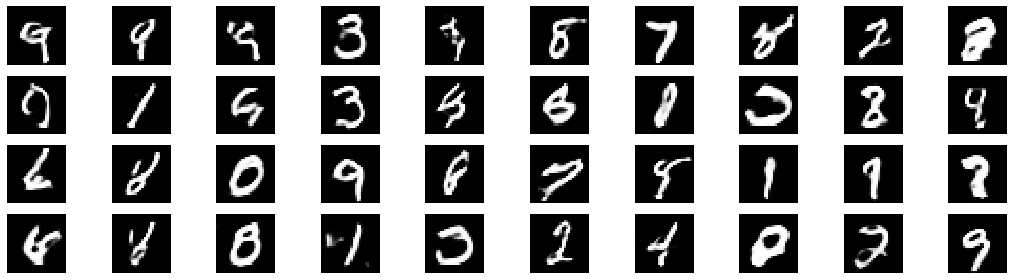

In [18]:
plt.figure(figsize=(15,4))

for i in range(40):
  #  noise = np.zeros([1,100]) - 1 + (i * 0.2)
    noise = np.random.uniform(-1.0, 1.0, size=[1, 100])
    images = net_gen.predict(noise)
    
    image = images[0, :, :, :]
    image = np.reshape(image, [28, 28])
          
    plt.subplot(4, 10, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

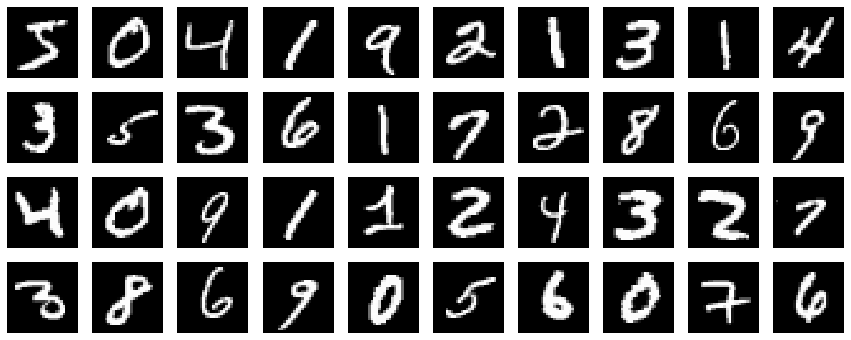

In [19]:
plt.figure(figsize=(15,6))

for i in range(40):
    image = X[i, :, :, :]
    image = np.reshape(image, [28, 28])
          
    plt.subplot(4, 10, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')